In [7]:
#Import relevant libraries
import math
import matplotlib.pyplot as plt
import numpy as np, pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
#Read data from CSV file
# data = pd.read_csv('/content/drive/MyDrive/Grad School-Files/Interpretable AI/diabetes.csv')
data = pd.read_csv('diabetes.csv')
data.head(10)
data.shape

(100000, 9)

In [10]:
#dummy code smkoing history

data_smoking = pd.get_dummies(data['smoking_history'])
data_smoking = data_smoking.drop(columns=['never', 'ever']) #Use people who have never been smokers as reference. 'ever' is a typo
data_gender = pd.get_dummies(data['gender'])
data_gender = data_gender.drop(columns=['Male']) #Use male as reference
data = pd.concat([data.drop(columns=['smoking_history', 'gender']), data_gender, data_smoking], axis=1)
data = data[data.Other != 1]
data = data.drop(columns=['No Info', 'not current', 'Other']) # Remove Other because only 18 people had this gender classification. Remove no info and not current in smoking history, as there isn't information about this


In [11]:
data

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,Female,current,former
0,80.0,0,1,25.19,6.6,140,0,1,0,0
1,54.0,0,0,27.32,6.6,80,0,1,0,0
2,28.0,0,0,27.32,5.7,158,0,0,0,0
3,36.0,0,0,23.45,5.0,155,0,1,1,0
4,76.0,1,1,20.14,4.8,155,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
99995,80.0,0,0,27.32,6.2,90,0,1,0,0
99996,2.0,0,0,17.37,6.5,100,0,1,0,0
99997,66.0,0,0,27.83,5.7,155,0,0,0,1
99998,24.0,0,0,35.42,4.0,100,0,1,0,0


In [12]:
#Get information about the columns
print(data.info())

#Check for null values
print('Are there any null values?: ', data.isnull().values.any())
print('Are there duplicate values?: ', data.duplicated())
print('Sum of null values: ', data.isnull().sum())
print('Sum of duplicated values :', data.duplicated().sum())

#Get descriptive statistics
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99982 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  99982 non-null  float64
 1   hypertension         99982 non-null  int64  
 2   heart_disease        99982 non-null  int64  
 3   bmi                  99982 non-null  float64
 4   HbA1c_level          99982 non-null  float64
 5   blood_glucose_level  99982 non-null  int64  
 6   diabetes             99982 non-null  int64  
 7   Female               99982 non-null  uint8  
 8   current              99982 non-null  uint8  
 9   former               99982 non-null  uint8  
dtypes: float64(3), int64(4), uint8(3)
memory usage: 6.4 MB
None
Are there any null values?:  False
Are there duplicate values?:  0        False
1        False
2        False
3        False
4        False
         ...  
99995     True
99996    False
99997    False
99998    False
99999    Fa

From the above descriptive statistics, note that the average individual in this dataset is overweight (average bmi > 25.0), very close to being prediabetic and/or has diabetes (mean HbA1C levels < 5.7, where levels above 5.7 indicates prediabeted. Mean blood glucose levels > 126mg/dL indicates diabetes). Note that the dataset does not mention fasting blood sugar levels or not. However, blood sugar levels are usually fasting levels, so we assume that's the case here too. Variables such as hypertension, heart disease and diabetes are actually categorical variables as they have 0 and 1 values.

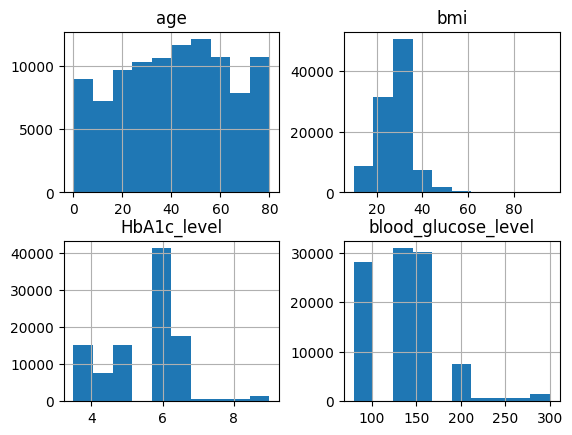

In [13]:
#Plot histograms of continuous variables to visualize the distribution
fig, ax = plt.subplots(2, 2)
cols= ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
m=0
for i in range(2):
    for j in range(2):
        data.hist(column = cols[m], ax=ax[i,j], figsize=(15, 12))
        m+=1

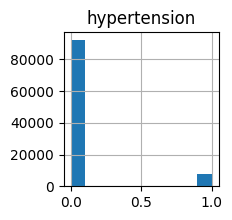

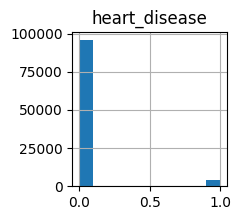

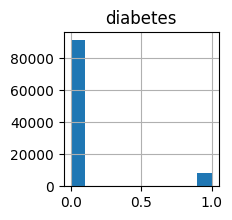

In [14]:
#Plot categorical variables
cols= ['hypertension', 'heart_disease', 'diabetes']
m=0
for i in range(3):
        data.hist(column = cols[m], figsize=(2, 2))
        m+=1

From the above graphs it is evident that the dataset is biased towards those who do not have hypertension, heat disease or diabetes. This needs to be considered when doing any kind of classification

<AxesSubplot:>

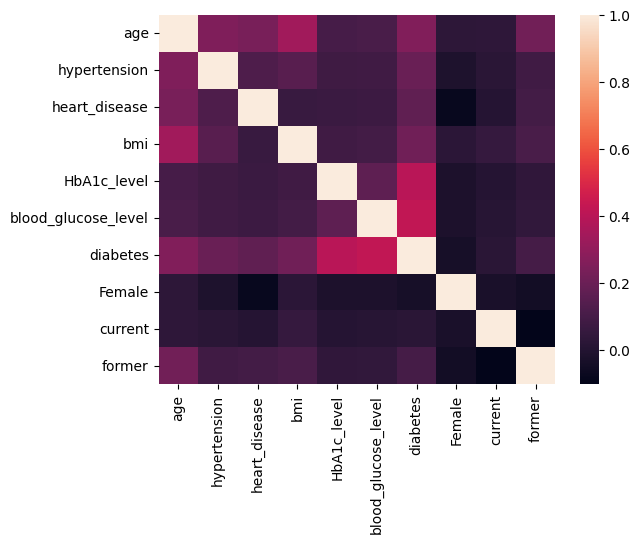

In [15]:
#Correlation plot
sns.heatmap(data.corr())

In [16]:
data.corr()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,Female,current,former
age,1.000000,0.251163,0.233352,0.337378,0.101343,0.110679,0.257999,0.030369,0.030917,0.216468
hypertension,0.251163,1.000000,0.121253,0.147679,0.080941,0.084436,0.197811,-0.014381,0.017914,0.083386
heart_disease,0.233352,0.121253,1.000000,0.061203,0.067591,0.070071,0.171718,-0.077886,0.007592,0.095184
bmi,0.337378,0.147679,0.061203,1.000000,0.083017,0.091310,0.214377,0.023023,0.053623,0.111322
HbA1c_level,0.101343,0.080941,0.067591,0.083017,1.000000,0.166831,0.400696,-0.020044,0.006117,0.037303
blood_glucose_level,0.110679,0.084436,0.070071,0.091310,0.166831,1.000000,0.419587,-0.017196,0.012450,0.040692
diabetes,0.257999,0.197811,0.171718,0.214377,0.400696,0.419587,1.000000,-0.037623,0.019588,0.097901
Female,0.030369,-0.014381,-0.077886,0.023023,-0.020044,-0.017196,-0.037623,1.000000,-0.026589,-0.049002
current,0.030917,0.017914,0.007592,0.053623,0.006117,0.012450,0.019588,-0.026589,1.000000,-0.102787
former,0.216468,0.083386,0.095184,0.111322,0.037303,0.040692,0.097901,-0.049002,-0.102787,1.000000


From the above matrix, we see that there is the highest correlation occurs between diabetes and blood sugar levels and HvA1C levels, which is unsurprising. Diabetes is somewhat related to hypertension, heart disease, age and bmi and not so much on smoking history

In [17]:
X = data.drop(columns=['diabetes'])
y = data['diabetes']

#Split data into training (66%) and test (33%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# With L2 Regularization (default logistic regression in sklearn)



In [18]:
from sklearn.linear_model import LogisticRegression

# define the model
model = LogisticRegression()
# fit the model
model.fit(X_train, y_train)
# get importance
importance = model.coef_[0]
print(importance)
print('Odds ratio: ', np.exp(importance))

[ 0.04292843  0.55401876  1.16361643  0.10996832  2.53338218  0.03082395
 -0.59073211  0.33000317  0.15213611]
Odds ratio:  [ 1.04386318  1.74023256  3.20149034  1.1162427  12.59603623  1.03130392
  0.5539216   1.39097253  1.16431871]


c:\Users\nqkhanh\learning\machineLearning\deepLearning\tf2x\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


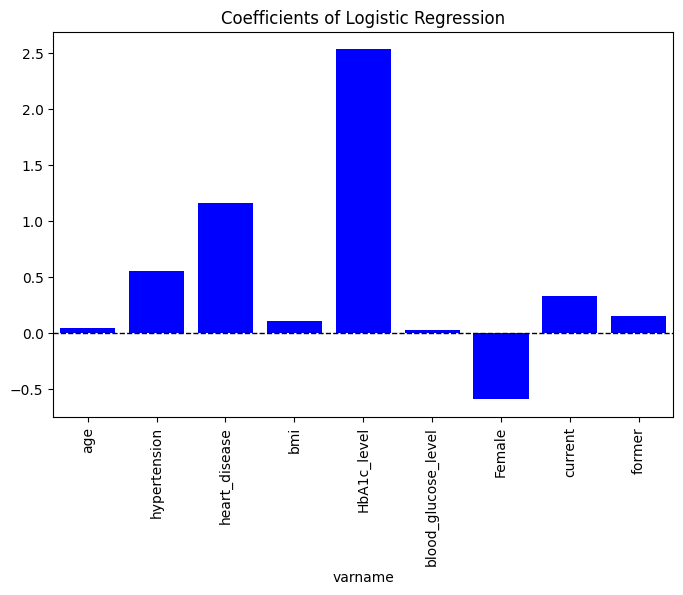

In [19]:
#Plot the weights
coef_df = pd.DataFrame({'coef': importance,
                        'varname': X_train.columns
                       })

coef_df.plot(y='coef', x='varname', kind='bar', color='none', legend=False, figsize=(8,5))
plt.bar(coef_df['varname'], coef_df['coef'], color='blue')
plt.axhline(y=0, linestyle='--', color='black', linewidth=1)
plt.title("Coefficients of Logistic Regression")
plt.show()

In [20]:
y_pred = model.predict(X_test)
print('Model accuracy: ', model.score(X_test, y_test)*100)

Model accuracy:  95.88119412032125


# With Weak Regularization



In [21]:
from sklearn.linear_model import LogisticRegression

# define the model
model = LogisticRegression(C=1e9)
# fit the model
model.fit(X_train, y_train)
# get importance
importance = model.coef_[0]
print(importance)
print('Odds ratio: ', np.exp(importance))

[ 0.03726399  0.3177322   2.33191199  0.08063525  2.26128309  0.03277511
 -0.10848486  0.08448797  0.31758996]
Odds ratio:  [ 1.037967    1.37400825 10.2976116   1.08397544  9.59539298  1.03331813
  0.89719248  1.08815976  1.37381283]


c:\Users\nqkhanh\learning\machineLearning\deepLearning\tf2x\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


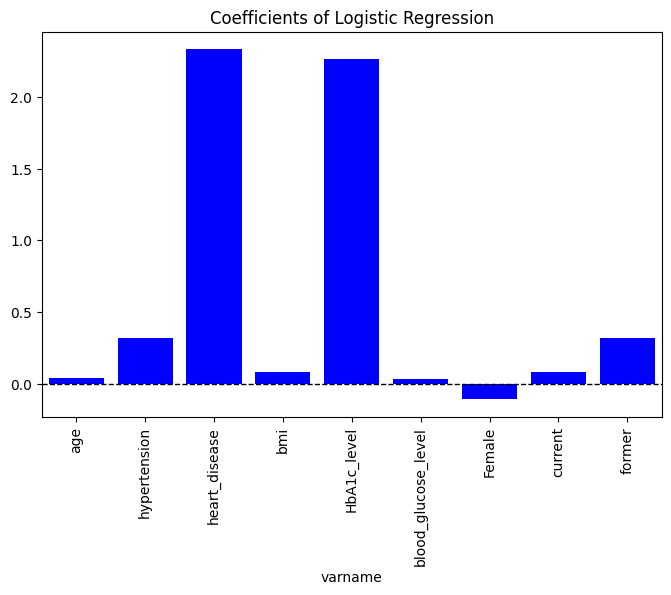

In [22]:
#Plot the weights
coef_df = pd.DataFrame({'coef': importance,
                        'varname': X_train.columns
                       })

coef_df.plot(y='coef', x='varname', kind='bar', color='none', legend=False, figsize=(8,5))
plt.bar(coef_df['varname'], coef_df['coef'], color='blue')
plt.axhline(y=0, linestyle='--', color='black', linewidth=1)
plt.title("Coefficients of Logistic Regression")
plt.show()

In [23]:
y_pred = model.predict(X_test)
print('Model accuracy: ', model.score(X_test, y_test)*100)

Model accuracy:  95.72359448401274
